<a href="https://colab.research.google.com/github/ZeroLeon/NLP_Project_with_FastAI/blob/master/TextCls_Taptap_fastai_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Clasiffication on Taptap reviews with fastai and Bert

## Background
- **Idea:** Nowadays mobile game plays a big role in the total income of China's internet giants such as Tencent or NetEase.  Players' reviews that indicating how people like the games may contain important information for predicting the trends of company's future performance. 

- **Data**:  [Taptap](https://taptap.com) is a famous mobile game community in China with player reviews and ratings. I scraped about 10000 player reviews under three hundred of games from Taptap as training and test dataset. 

## Project Overview:

1. Data collection (from Taptap) 
2. Data Pre-Process (Clean, Drop, Transform) 
3. Data Process with fastai 
4. Fine-tune Model 
5. Check the model performance on Test dataset
6. Use the model on similar texts in same domain. (from game platforms, forums, social media etc.) 
7. Evaluate the Result


##Preparation

In [0]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [0]:
#Set up a config class to save or change the parameters 
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name='bert-base-chinese', 
    max_lr=2e-5,#The recommended lr is 3e-5 in bert paper, but 2e-5 is better in this project
    epochs=1,
    use_fp16=False, #learner.to_fp16() Mixup precision can speedup training
    bs=8,
    max_seq_len=256, # Max sequence length in bert is 512
    num_labels = 2 , # 0:negative, 1:positive. For this project.
)

In [3]:
#Load google drive
import os 
from pathlib import Path
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)
base_dir = '/content/gdrive/My Drive/fastai'
path = Path(base_dir +'/data/taptap_comment')
path.mkdir(parents=True,exist_ok=True)
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
pwd

'/content/gdrive/My Drive/fastai/data/taptap_comment'

In [0]:
!pip install pytorch_pretrained_bert

##Dataset



**Pre-Process:**
- Data cleaning
- Drop columns irrelevent 
- Drop NaN 
- Set reviews to positive (4 or 5 stars) and negtive (1,2,3 stars)
- Set Min sequence length to filter text too short

In [10]:
#The processed test dataset
df_test = pd.read_csv('taptap_test_ready.csv')
df_test.head(10)

,review,stars,sentiment
0,关于游戏抄袭不抄袭的我不清楚也不想在这方面讲这游戏，玩这游戏一开始还觉得还算有趣，但初始就3...,width: 56px,1
1,游戏画风很清新，音乐也很轻快，操作简单，仅需靠划屏操作绕开障碍物和所谓天空守卫的视野范围来收...,width: 70px,1
2,别有新意的游戏。好可爱！一开始字幕闪得有些快（呃也可能是我没集中注意_(:з)∠)_）后来试...,width: 70px,1
3,大概玩了二十几分钟 一开始以为就是要从种子开始培养成大树的那种 出乎意料的好像给我上了一节生...,width: 56px,1
4,不要放弃挣扎，这款游戏我玩了很久，现在没玩了想回来找结果没得下载了，有个新游戏叫凡尘修仙的跟...,width: 70px,1
5,神回避一直是我玩过的最好玩的解谜游戏啦！游戏性真的太强，而且可以给主角使用任何拾取的道具，风...,width: 70px,1
6,给新玩家建议，1:想霸服，万元起步。2:大佬，五千以上3:精英玩家:三千左右4:游戏混子，首...,width: 42px,0
7,很喜欢，但是bug真的严重，卡死的问题跟其他玩家反馈的一样，不明原因的无法移动，对着可消除元...,width: 56px,1
8,好玩是好玩，可是会闪退。每次闪退后游戏进度就变成好几分钟前的样子了。我都忍了。直到我这次做任...,width: 56px,1
9,游戏本身是比较可爱的模拟经营玩法，主要是开甜品店，虽然我比较希望能在真实世界开个赛百味之类的...,width: 70px,1


In [0]:
# Training dataset
df_train = pd.read_csv(path/'taptap_review_ready.csv')

In [12]:
df_train.sample(10)

,review,sentiment
3445,联网的放置挂机游戏，游戏功能按钮很多，瞎玩的话开局很难成长。所以有QQ群里找开局攻略这么一说...,1
988,开服玩家，今天37级了，本想等平妖司里的功能出了再评论，因为觉得这个游戏还没做完。但等不及了...,0
2803,期待题材，就像问问战斗方式，如果像啪啪三国就好了，操作空间大。,1
3922,7.12算上原作加成我能给四星，不过单纯游戏而言三星吧。1.游戏模式明显可以看出来模仿火纹，...,0
1466,一个脑洞很大的游戏，对于我这种智商不够用的人，有些关不看攻略的话，估计永远也过不去了。不过有...,1
1512,刚开始见到这只有2.91MB的安装包时，我还以为自己下错了，进了一个假的官网，还下了个假的游...,1
3871,给个4星吧ԅ(¯ㅂ¯ԅ)游戏的想法是不错的，moba加放置（顺利条件吸水晶什么鬼）_(:з」...,1
3313,游戏总体上来说不错， 这游戏我也关注几个月了，那么现在我就稍稍的评价一下。首先，游戏画质很好...,0
4311,我進遊戲半天，一個人都沒，然後想觀戰，也是空空如也，一首涼涼送給這個遊戲,0
2811,从10点到现在体验了2个小时◆喜欢◆◇音乐好评，但是太单一◇UI界面好评，要是按钮能大一点就...,1


In [13]:
label_representation = {1:'positive',0:'negative'}
df_train.sentiment.value_counts()

0    2458
1    2430
Name: sentiment, dtype: int64

Training dataset is balanced.

##Using BERT with fast.ai

**A few things need to be noticed in fast.ai and Bert：**



1.   Bert has its own wordpiece tokenizer, Anne already showed that.
2.   Bert uses token [CLS] 和 [SEP] to mark sequences, this conflicts with bos(begin of string) and eos in fastai , that's why we have "include_eos=Fasle" later.
3.   Bert has it's own vocabulary. For Chinese pre-trained Model,  the vocab is based on Characters, not on words.

Thanks to [A Tutorial to Fine-Tuning BERT with Fast AI](http://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) , some codes here is borrowed from this article.

In [14]:
#Import the tokenizer
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

100%|██████████| 109540/109540 [00:00<00:00, 657068.62B/s]


In [17]:
bert_tok.tokenize('哈尔滨简称哈市，别名冰城、東方莫斯科')

['哈',
 '尔',
 '滨',
 '简',
 '称',
 '哈',
 '市',
 '，',
 '别',
 '名',
 '冰',
 '城',
 '、',
 '東',
 '方',
 '莫',
 '斯',
 '科']

In [0]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
fastai_tokenizer = Tokenizer(
    tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), 
    pre_rules=[], 
    post_rules=[]
)

In [22]:
#check the vocab
list(bert_tok.vocab.items())[2100:2110]

[('存', 2100),
 ('孙', 2101),
 ('孚', 2102),
 ('孛', 2103),
 ('孜', 2104),
 ('孝', 2105),
 ('孟', 2106),
 ('孢', 2107),
 ('季', 2108),
 ('孤', 2109)]

In [0]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

##Setup and Save Databunch

In [0]:
#Split training and validation set, set random_state to ensure repeatability 
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df_train,random_state=42)

In [0]:
#When dataset is large, we can use small subset to test it quickly
if config.testing:
  train = train_df.head(1024)
  valid = valid_df.head(1024)
else:
  train = train_df
  valid = valid_df

In [27]:
print(train.shape)
print(valid.shape)

(3666, 2)
(1222, 2)


In [0]:
text_cols  = ['review']
label_cols = ['sentiment']

In [0]:
#建立 TextDataBunch
databunch = TextClasDataBunch.from_df(".", train, valid, df_test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols= text_cols,
                  label_cols= label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [31]:
databunch.show_batch(5)

text,target
[CLS] 我 觉 得 二 测 就 是 你 们 找 削 吧 。 。 。 。 之 前 ( 一 测 ) 都 说 过 ， 火 柴 皮 肤 价 格 有 些 高 了 ， 你 还 来 ， 阿 可 斯 的 2017 ! 我 不 知 道 怎 么 说 ， 你 皮 肤 有 属 性 加 成 的 好 吧 ! 其 它,0
[CLS] 试 玩 了 下 ， 开 始 想 着 按 自 己 的 想 法 走 ， 把 1 房 的 人 给 救 了 ， 但 后 来 女 儿 生 病 了 ， 高 昂 的 医 疗 费 不 得 不 让 我 开 始 敲 诈 房 客 ， 不 得 不 按 着 部 长 的 话 做 ， 但 最 后 换 来,1
[CLS] 周 年 祭 。 广 告 说 的 很 好 。 佛 性 游 戏 确 实 太 佛 了 。 这 么 说 ， 一 个 礼 包 64 ##8 ， 含 有 80 高 抽 。 结 果 这 80 高 抽 可 以 抽 到 什 么 呢 ？ 可 以 抽 到 三 星 一 堆 一 堆 有 一 堆 。 四 星 几,0
[CLS] 肝 了 挺 长 时 间 了 ， 但 ta ##p 就 是 不 给 我 算 上 游 戏 时 间 - _ - | | 像 素 风 从 来 就 是 我 很 喜 欢 的 风 格 ， 冲 这 先 给 个 第 一 印 象 的 好 评 刚 进 入 游 戏 ， 新 手 指 导 也 挺 人 性 化,1
[CLS] 虽 然 常 年 沉 迷 各 种 益 智 游 戏 但 是 依 旧 智 障 的 我 [UNK] [UNK] [UNK] （ 就 算 天 天 玩 也 还 是 并 不 能 获 得 高 分 ） 消 除 玩 法 的 创 意 很 棒 ！ 以 前 没 有 见 过 同 款 的 极 简 风 格 也 非 常 讨 喜 ！,1


In [40]:
databunch.train_ds.get_state

<bound method LabelList.get_state of LabelList (3666 items)
x: TextList
[CLS] 虽 然 掉 王 者 260 杯 了 但 实 力 偏 上 吧 我 想 发 表 几 个 观 点 不 喜 勿 喷 第 一 翠 竹 棒 特 点 是 铁 链 很 硬 但 是 一 块 石 头 一 下 子 就 能 砸 烂 两 根 而 且 15 跟 翠 竹 需 要 250 香 蕉 。 比 它 好 用 2 倍 的 * * * 才 200 香 蕉 好 吧 ， 前 期 解 锁 了 翠 竹 的 朋 友 相 信 跟 我 小 号 一 样 玩 不 走 了 第 二 钢 筋 版 这 么 说 吧 钢 筋 绳 子 比 翠 竹 的 铁 链 硬 板 子 比 合 金 版 强 今 天 有 幸 碰 到 过 一 个 用 钢 筋 版 的 玩 家 我 用 松 鼠 打 了 5 个 回 合 板 子 才 裂 一 点 小 缝 比 武 士 棍 实 用 3 倍 但 是 制 造 价 格 很 贵 ， 4000 香 蕉 15 根 贫 民 必 定 用 不 起 ， 所 以 匹 配 到 钢 筋 的 别 尝 试 割 绳 子 啃 板 子 了 直 接 退 游 重 来 吧 第 三 这 游 戏 现 在 我 一 天 玩 不 过 20 分 钟 了 香 蕉 不 够 用 用 低 级 板 子 跟 送 分 没 多 大 区 [SEP],[CLS] 调 戏 完 客 服 小 哥 哥 决 定 给 个 五 星 好 评 ( [UNK] • [UNK] • [UNK] ) [UNK] . 衔 接 不 太 好 ， 会 卡 ， 2 . 界 面 过 于 简 单 ， 可 以 丰 富 下 颜 色 ， 多 点 小 形 象 ， 3 . 熟 悉 的 游 戏 套 路 ， 只 不 过 又 有 了 一 个 叫 做 氧 气 瓶 的 东 西 ， 4 . 可 玩 性 有 待 提 高 ， 加 点 难 度 打 几 个 小 怪 是 个 好 套 路 ， 5 . 画 质 优 化 一 下 会 比 较 好 ， 颜 色 丰 富 一 些 ， 6 . 可 以 氪 金 提 高 装 备 ， 补 充 装 备 之 类 的 ， 7 . 声 优 很 简 单 的 ~ 有 点 傻 ， 希 望 有 更 多 的 人 物 形 象 ， 角 色 不 要 太 僵 硬 ， 出 一 些 立 绘 ， 皮 

In [65]:
databunch.test_ds.get_state

<bound method LabelList.get_state of LabelList (5336 items)
x: TextList
[CLS] 关 于 游 戏 抄 袭 不 抄 袭 的 我 不 清 楚 也 不 想 在 这 方 面 讲 这 游 戏 ， 玩 这 游 戏 一 开 始 还 觉 得 还 算 有 趣 ， 但 初 始 就 3 个 角 色 虽 然 说 这 三 角 色 都 还 行 但 感 觉 平 衡 性 不 是 特 别 好 ， 然 后 就 是 游 戏 过 程 中 有 部 分 玩 家 挂 机 ( 虽 然 说 不 是 公 测 但 这 样 的 行 为 还 是 要 有 相 关 的 系 统 给 挂 机 玩 家 予 以 惩 罚 ) ， 并 且 在 游 戏 中 我 逐 渐 发 现 有 些 奇 怪 的 玩 家 ( 拥 有 昂 贵 的 英 雄 ， 各 式 各 样 的 皮 肤 ， 能 直 接 看 出 草 丛 里 有 没 有 人 的 一 类 玩 家 ) ， 他 们 甚 至 会 在 草 被 炸 掉 的 草 上 不 动 回 血 ， 慢 慢 我 发 现 这 是 人 机 ， 一 开 始 我 还 是 比 较 理 解 的 ， 因 为 游 戏 玩 家 不 是 特 别 多 会 导 致 部 分 时 段 匹 配 时 间 长 ， 安 排 人 机 也 可 以 提 高 刚 入 门 玩 家 的 [SEP],[CLS] 游 戏 画 风 很 清 新 ， 音 乐 也 很 轻 快 ， 操 作 简 单 ， 仅 需 靠 划 屏 操 作 绕 开 障 碍 物 和 所 谓 天 空 守 卫 的 视 野 范 围 来 收 集 物 品 进 行 通 关 。 对 于 频 繁 自 动 弹 出 的 广 告 我 表 示 理 解 ， 毕 竟 都 是 要 恰 饭 的 。 游 戏 唯 一 美 中 不 足 的 就 是 难 度 太 低 ， 后 边 无 尽 模 式 反 而 显 得 多 余 ， 希 望 提 高 游 戏 的 难 度 和 地 图 的 数 量 。 [SEP],[CLS] 别 有 新 意 的 游 戏 。 好 可 爱 ！ 一 开 始 字 幕 闪 得 有 些 快 （ 呃 也 可 能 是 我 没 集 中 注 意 _ ( : з ) ∠ ) _ ） 后 来 试 着 点 了 两 下 突 然 就 了 然 啦 ， 立 马 觉 得 超 可 爱 ！ 小 小 的 机 

In [0]:
databunch.save(path/'taptap_databunch.pkl')

## Model

In [42]:
# We can also use pytorch hub to import bert-pretrained model

bert_model = torch.hub.load('huggingface/pytorch-pretrained-BERT', 
                            'bertForSequenceClassification', 
                             config.bert_model_name, 
                             num_labels=config.num_labels)

Downloading: "https://github.com/huggingface/pytorch-pretrained-BERT/archive/master.zip" to /root/.cache/torch/hub/master.zip
100%|██████████| 382072689/382072689 [00:15<00:00, 25414730.89B/s]


In [0]:
bert_model.eval()

In [0]:
#Loss function for multiclass problem
loss_func = nn.CrossEntropyLoss()

In [0]:
learner = Learner(
    databunch, 
    bert_model,
    loss_func=loss_func,
    metrics=[accuracy]
)

In [46]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
learner.recorder.plot(skip_end=10)

In [49]:
#Start training
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.414134,0.411563,0.825696,05:44


In [0]:
learner.save('stage1')

In [111]:
learner.fit_one_cycle(3, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.424804,0.445691,0.798691,05:15
1,0.286135,0.483049,0.813421,05:23
2,0.123566,0.565216,0.809329,05:46


Usually it takes several epochs to get a pretty good result

In [0]:
#Get predictions of test dataset in order
def get_preds_ordered(ds_type,learner = learner):
    """
    The get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [0]:
# Setup a function to get metrics of test dataset
from sklearn.metrics import accuracy_score,f1_score

def print_test_metrics(true_labels,learner = learner):
  preds = get_preds_ordered(DatasetType.Test,learner)
  pred_values = np.argmax(preds, axis = 1)
  acc, f1s = accuracy_score(true_labels,pred_values),f1_score(true_labels,pred_values)
  print(f'The accuracy is {round(acc*100,2)}%, the f1_score is {round(f1s*100,2)}%')

In [0]:
# preds = get_preds_ordered(DataseType.Test)
# pred_values = np.argmax(preds,axis=1)
# acc, f1s = accuracy_score(true_labels,pred_values),f1_score(true_labels,pred_values)
# print(f'The accuracy is {round(acc*100,2)}%, the f1_score is {round(f1s*100,2)}%')

In [0]:
true_labels = np.array(df_test.sentiment.tolist())

In [140]:
print_test_metrics(true_labels)

The accuracy is 80.92%, the f1_score is 86.05%


##Interpretation with fast.ai

In [0]:
intepret = TextClassificationInterpretation.from_learner(learner)

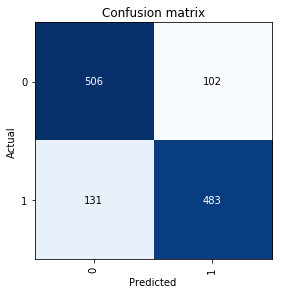

In [116]:
intepret.plot_confusion_matrix()

In [117]:
intepret.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
[CLS] cg 字 幕 太 低 ， 看 不 到 。 這 遊 戲 如 果 是 500 元 一 次 性 收 價 ， 我 會 買 ， 但 現 在 [UNK] 金 系 統 太 可 怕 又 要 收 費 包 又 要 抽 外 觀 有 加 成 又 要 買 機 率 ， 雖 然 本 人 不 追 求 排 名 ， 但 這,0,0,6.72,1.00
[CLS] 这 游 戏 成 功 让 我 了 解 到 了 什 么 是 真 正 的 脸 皮 厚 ， 名 子 叫 mc ， 进 去 一 看 ， 迷 你 世 界 ？ ， 全 人 机 不 说 ， 广 告 是 什 么 玩 意 啊 ！ 而 且 一 上 来 就 要 钱 ， 说 什 么 强 化 装 备 ？,0,0,6.63,1.00
[CLS] 4 分 给 美 术 风 格 和 探 索 精 神 。 但 这 个 评 论 ， 还 是 想 探 讨 下 关 于 [UNK] 战 棋 [UNK] 的 定 义 ， 毕 竟 打 了 [UNK] 轻 战 棋 [UNK] 的 旗 号 ， 面 向 了 某 类 用 户 ， 关 于 这 个 命 题 躲 不 掉 。 什 么 是,0,1,6.59,0.00
[CLS] 游 戏 体 验 并 不 是 那 么 良 好 ， 开 始 的 时 候 无 故 跳 转 到 乱 七 八 糟 的 小 程 序 ， 卡 顿 了 一 下 就 进 去 了 x 第 一 关 点 重 开 的 时 候 咔 地 闪 退 了 但 是 后 面 的 游 戏 还 是 蛮 顺 畅 的 ，,0,1,6.55,0.00
[CLS] 画 风 很 有 意 境 ， 有 国 风 的 感 觉 ， 音 乐 也 还 算 配 ， 只 是 和 评 论 里 说 的 一 样 过 关 时 候 一 声 y ##ea ##h 有 点 不 妥 。 但 这 都 不 是 大 毛 病 ， 游 戏 不 足 在 于 难 度 太 高 ， 不 用 叶 子,0,1,6.43,0.00


## Several ways to improve the fine-tuning results

### Chinese BERT with Whole Word Masking

The whole word masking exmaple from [here](https://github.com/ymcui/Chinese-BERT-wwm)



|  Text    | Example  |
|  ----  | ----  |
| Oringinal Text  | 使用语言模型来预测下一个词的probability |
| Tokenized Text  | 使用 语言 模型 来 预测 下 一个 词 的 probability |
|  Oringinal Masking Text             |     使 用 语 言 [MASK] 型 来 [MASK] 测 下 一 个 词 的 pro [MASK] ##lity         |
| WWM Text  |  使 用 语 言 [MASK] [MASK] 来 [MASK] [MASK] 下 一 个 词 的 [MASK] [MASK] [MASK]     |

In [0]:
path_model = Path('/content/gdrive/My Drive/fastai/models_process/bert_chinese_wwm/bert_chinese_wwm')

In [0]:
from pytorch_pretrained_bert import BertForSequenceClassification
bert_wwm_model = BertForSequenceClassification.from_pretrained(path_model,num_labels=2)

In [0]:
learner_wwm = Learner(
    databunch, 
    bert_wwm_model,
    loss_func=loss_func,
    metrics=[accuracy]
)

In [142]:
learner_wwm.fit_one_cycle(1,2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.469907,0.419834,0.814239,05:03


In [143]:
learner_wwm.fit_one_cycle(3,2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.435672,0.461473,0.799509,05:25
1,0.360289,0.405621,0.821604,05:42
2,0.183317,0.479112,0.820786,05:44


In [146]:
print_test_metrics(true_labels,learner=learner_wwm)

The accuracy is 82.07%, the f1_score is 87.1%


The result gets about 1% better.

## BERT Model Finetuning using Masked Language Modeling objective



We have learnt ULMFiT in fast.ai. That means in transfer learning of NLP,  we can train a laguage model **on text from the same domain as the target task and using the pretraining objective**. Then we can use this language model in our downsteam tasks like text classification.
![替代文字](http://nlp.fast.ai/images/ulmfit_approach.png)

But for Bert things are a little deferent. The oringial Bert paper don't have this kind of step in downstream tasks.  The classifier head is added directly on top of the pre-trained architecture and quickly fine-tuned on a target task. 



People may ask: What if we add a similar step on Bert model training process? Will it improve the performance?


---


**The answer to the question “Should I try blah?” is to try blah and see, that’s how you become a good practitioner 
-- Jeremy Howard**



This is totally right and we should always bear that in mind.  So I decided to try it myself and found a way  [here](https://github.com/huggingface/pytorch-pretrained-BERT/tree/master/examples/lm_finetuning).

In [0]:
path_lm = Path('/content/gdrive/My Drive/fastai/models_process/lm_finetune_bert')

In [0]:
os.chdir(path_lm)

In [0]:
!python3 pregenerate_training_data.py \
--train_corpus output.txt \
--bert_model bert-base-chinese \
--output_dir training/ \
--epochs_to_generate 3 \
--max_seq_len 128

In [0]:
!python3 finetune_on_pregenerated.py \
--pregenerated_data training/ \
--bert_model bert-base-chinese \
--output_dir finetuned_lm/ \
--epochs 3

In [0]:
bert_lm_model = BertForSequenceClassification.from_pretrained(path_lm/'finetuned_lm',num_labels=2)

In [0]:
learner_lm = Learner(
    databunch, 
    bert_lm_model,
    loss_func=loss_func,
    metrics=[accuracy]
)

In [158]:
learner_lm.fit_one_cycle(1,2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.465912,0.427113,0.822422,05:33


In [159]:
learner_lm.fit_one_cycle(3,2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.405441,0.483528,0.787234,05:25
1,0.319010,0.434057,0.822422,05:27
2,0.211083,0.506716,0.819149,05:33


In [160]:
print_test_metrics(true_labels,learner = learner_lm)

The accuracy is 81.77%, the f1_score is 86.96%


Better than original but not as good as wwm.

## Simplely compare to SnowNLP

[SnowNLP](https://github.com/isnowfy/snownlp): Simplified Chinese Text Processing.
It is a NLP python package widely used before. Let's see what result we can get from it.

In [0]:
!pip install snownlp

In [0]:
from snownlp import SnowNLP

In [0]:
def snow(text):
  out = SnowNLP(text)
  return round(out.sentiments)

In [0]:
df_test['snow_out'] = df_test.review.apply(snow)

In [0]:
snow_preds = np.array(df_test.snow_out.tolist())

In [178]:
acc_snow = accuracy_score(true_labels, snow_preds)
f1_snow = f1_score(true_labels, snow_preds)
print(f'For SnowNLP, the accuracy is {round(acc_snow*100,2)}%, the f1_score is {round(f1_snow*100,2)}%')

For SnowNLP, the accuracy is 68.01%, the f1_score is 77.51%


## Why fast.ai is so awsome?
**The top-down learning strategy lower the threshhold for common people to be a deep learning practitioner.**


- With fastai, you could jump out to see the big picture. You won't get yourself lost in a bunch of math equations and matrix graphs on the early stage.
- With fastai it's much easier to use pre-trained model and  plug them into your own specific project.




## Let's implement ideas of NLP together  with fastai!